In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

In [2]:
x_train = pd.read_csv('.\\data\\train.csv')
x_test = pd.read_csv('.\\data\\test.csv')

In [3]:
print('Número de colunas são: ')
print('Dados de treino {}\nDados de teste {}'.format(len(x_train.columns), len(x_test.columns)))

Número de colunas são: 
Dados de treino 167
Dados de teste 47


# Simulando ambiente de submissão ...

Inicialmente a estrategia utilizada será de igualar os dados, isto é, deixar os dados de treino que contém mais colunas com o mesmo número que o teste com intuito de permitir uma simulação com os dados que serão encontrados na submissão

In [4]:
# Armazenando a resposta e a presença em matematica
y_train = x_train['NU_NOTA_MT']
x_train_presenca_mt = x_train['TP_PRESENCA_MT']

# Deixando o dataframe de treino igual ao de teste
x_train = x_train[x_test.columns.tolist()]

# Adicionando as notas de matemática novamente, para ánalise posterior
x_train['NU_NOTA_MT'] = y_train
x_train['TP_PRESENCA_MT'] = x_train_presenca_mt

In [5]:
len(x_test)

4576

In [6]:
def renomear_colunas(dataframe):
    lista_colunas = dataframe.columns.map(lambda x: x.lower())
    tamanho_lista = len(lista_colunas)
    for i in range(0, tamanho_lista):
        dataframe.rename(columns={dataframe.columns[i]:lista_colunas[i]}, inplace=True)
        
renomear_colunas(x_train)
renomear_colunas(x_test)

# 2. Preprocessamento

Etapa onde é realziado a abordagem sobre os dados para realização de limpeza, adição de novas informações e preenchimento de dados faltantes. A lista abaixo representa as atividades realizadas:

<b>2.1 Analisando e criando novas informações</b><br>
<b>2.2 Descobrindo padrões</b><br>
<b>2.3 Conclusão</b><br>
<b>2.3.1 Trabalhando dados faltantes (<i>outliers</i>)</b><br>

## 2.1 Analisando e criando novas informações

In [7]:
def categoria_status_conclusao(status):
    # 1 Já concluí o Ensino Médio, 2 Estou cursando e concluirei o Ensino Médio em 2016
    # 3 Estou cursando e concluirei o Ensino Médio após 2016, 4 Não concluí e não estou cursando o Ensino Médio 
    if status == 1:
        return 'concluiu'
    elif status == 2:
        return 'em_conclusao' 
    elif status == 3:
        return 'cursando'
    elif status == 4:
        return 'nao_fazendo'
    
def categoria_tipo_escola(tp_escola):
    # 1 Não Respondeu, 2 Pública, 3 Privada, 4 Exterior
    if tp_escola == 1:
        return 'nao_respondeu'
    elif tp_escola == 2:
        return 'publica'
    elif tp_escola == 3:
        return 'privada'
    elif tp_escola == 4:
        return 'exterior'
    
def dependencia_administrativa(dependencia):
    # 1 Federal, 2 Estadual, 3 Municipal, 4 Privada
    if dependencia == 1:
        return 'federal'
    elif dependencia == 2:
        return 'estadual'
    elif dependencia == 3:
        return 'municipal'
    elif dependencia == 4:
        return 'privada'

def pre_processamento(dataframe):
    df_proc = dataframe.copy()
    print(len(df_proc))
    # Adicionando ao dado original as novas variáveis categoricas
    df_proc['tp_st_conclusao_cat'] = df_proc.tp_st_conclusao.apply(lambda x: categoria_status_conclusao(x))
    df_proc['tp_escola_cat'] = df_proc.tp_escola.apply(lambda x: categoria_tipo_escola(x))
    df_proc['tp_dependencia_adm_esc_cat'] = df_proc.tp_dependencia_adm_esc.apply(lambda x: dependencia_administrativa(x))
    df_proc['tp_sexo'] = df_proc['tp_sexo'].apply(lambda c: 'masculino' if c == 'M' else 'feminino')
    print(len(df_proc))
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
    
    dummy_features = ['tp_st_conclusao_cat', 'tp_escola_cat', 'tp_dependencia_adm_esc_cat', 'tp_sexo', 'q006']
    df_proc = pd.concat([df_proc, pd.get_dummies(df_proc[dummy_features], prefix=dummy_features)], axis = 1)
    print(len(df_proc))
    return df_proc

x_train = pre_processamento(x_train)
list(x_train.columns)

13730
13730
13730


['nu_inscricao',
 'co_uf_residencia',
 'sg_uf_residencia',
 'nu_idade',
 'tp_sexo',
 'tp_cor_raca',
 'tp_nacionalidade',
 'tp_st_conclusao',
 'tp_ano_concluiu',
 'tp_escola',
 'tp_ensino',
 'in_treineiro',
 'tp_dependencia_adm_esc',
 'in_baixa_visao',
 'in_cegueira',
 'in_surdez',
 'in_dislexia',
 'in_discalculia',
 'in_sabatista',
 'in_gestante',
 'in_idoso',
 'tp_presenca_cn',
 'tp_presenca_ch',
 'tp_presenca_lc',
 'co_prova_cn',
 'co_prova_ch',
 'co_prova_lc',
 'co_prova_mt',
 'nu_nota_cn',
 'nu_nota_ch',
 'nu_nota_lc',
 'tp_lingua',
 'tp_status_redacao',
 'nu_nota_comp1',
 'nu_nota_comp2',
 'nu_nota_comp3',
 'nu_nota_comp4',
 'nu_nota_comp5',
 'nu_nota_redacao',
 'q001',
 'q002',
 'q006',
 'q024',
 'q025',
 'q026',
 'q027',
 'q047',
 'nu_nota_mt',
 'tp_presenca_mt',
 'tp_st_conclusao_cat',
 'tp_escola_cat',
 'tp_dependencia_adm_esc_cat',
 'tp_st_conclusao_cat_concluiu',
 'tp_st_conclusao_cat_cursando',
 'tp_st_conclusao_cat_em_conclusao',
 'tp_st_conclusao_cat_nao_fazendo',
 'tp_es

In [8]:
vars_notas = ['nu_nota_mt','nu_nota_cn', 'nu_nota_ch', 'nu_nota_lc','nu_nota_redacao']
x_train[vars_notas]

,nu_nota_mt,nu_nota_cn,nu_nota_ch,nu_nota_lc,nu_nota_redacao
0,399.4,436.3,495.4,581.2,520.0
1,459.8,474.5,544.1,599.0,580.0
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
13725,403.2,438.2,419.7,394.5,440.0
13726,452.4,423.8,557.9,533.0,560.0
13727,398.0,460.5,528.9,569.3,600.0
13728,386.6,422.5,621.7,569.0,460.0


In [9]:
def correlations_plot(dataframe, corr_columns):
    dfcorr = dataframe.loc[:, corr_columns]
    corr = dfcorr.corr()
    sns.heatmap(corr, vmin=0, vmax=1, annot=True, cmap=sns.color_palette("BrBG", 100))

## 2.2 Descobrindo padrões

A primeira informação que eu gostaria de saber é a correlação entre as provas e a respectiva presença.

In [10]:
vars_presenca = ['tp_presenca_cn', 'tp_presenca_ch', 'tp_presenca_lc', 'tp_presenca_mt']
x_train[vars_presenca].describe().T

,count,mean,std,min,25%,50%,75%,max
tp_presenca_cn,13730.0,0.754479,0.431932,0.0,1.0,1.0,1.0,2.0
tp_presenca_ch,13730.0,0.754479,0.431932,0.0,1.0,1.0,1.0,2.0
tp_presenca_lc,13730.0,0.738747,0.440162,0.0,0.0,1.0,1.0,2.0
tp_presenca_mt,13730.0,0.738747,0.440162,0.0,0.0,1.0,1.0,2.0


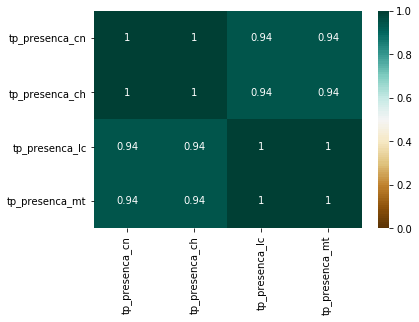

In [11]:
correlations_plot(x_train, vars_presenca)

### Analisar a nota da redação

In [12]:
vars_redacao = ['tp_status_redacao', 'nu_nota_comp1', 'nu_nota_comp2', 'nu_nota_comp3',
                'nu_nota_comp4', 'nu_nota_comp5', 'nu_nota_redacao']
x_train_redacao = x_train[vars_redacao]
x_train_redacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tp_status_redacao  10133 non-null  float64
 1   nu_nota_comp1      10133 non-null  float64
 2   nu_nota_comp2      10133 non-null  float64
 3   nu_nota_comp3      10133 non-null  float64
 4   nu_nota_comp4      10133 non-null  float64
 5   nu_nota_comp5      10133 non-null  float64
 6   nu_nota_redacao    10133 non-null  float64
dtypes: float64(7)
memory usage: 751.0 KB


In [13]:
x_train_redacao.describe().T

,count,mean,std,min,25%,50%,75%,max
tp_status_redacao,10133.0,1.101747,0.700100,1.0,1.0,1.0,1.0,9.0
nu_nota_comp1,10133.0,119.811704,29.846017,0.0,120.0,120.0,140.0,200.0
nu_nota_comp2,10133.0,111.915918,33.737588,0.0,100.0,120.0,120.0,200.0
nu_nota_comp3,10133.0,106.824238,34.341349,0.0,80.0,120.0,120.0,200.0
nu_nota_comp4,10133.0,113.123951,33.480033,0.0,100.0,120.0,120.0,200.0
nu_nota_comp5,10133.0,77.372446,43.067140,0.0,40.0,80.0,100.0,200.0
nu_nota_redacao,10133.0,529.048258,154.294758,0.0,440.0,540.0,600.0,1000.0


In [14]:
x_train_redacao = x_train[vars_redacao]
x_train_redacao = x_train_redacao[x_train_redacao.tp_status_redacao.isna()]
x_train_redacao.describe().T

,count,mean,std,min,25%,50%,75%,max
tp_status_redacao,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nu_nota_comp1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nu_nota_comp2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nu_nota_comp3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nu_nota_comp4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nu_nota_comp5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nu_nota_redacao,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.3 Conclusão

A partir da análise da presença dos alunos pôde se descobrir que:

[1] Alunos que realizaram matemática também fizeram linguagens;<br>
[2] Alunos que realizaram ciências humanas fizeram ciências da natureza.

<b>Com essa informação podemos preencher os dados faltantes (<i>outliers</i>) nos dados com zeros a nota de matemática sabendo a informação [1].</b>

### 2.3.1 Preenchendo dados faltantes

In [15]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html
def executar_conclusao(dataframe, train):
    df_conclusao = dataframe.copy()
    if train:
        df_conclusao.loc[df_conclusao.tp_presenca_lc.isin([0, 2]), ['nu_nota_mt', 'nu_nota_lc']] = 0
    else:
        df_conclusao.loc[df_conclusao.tp_presenca_lc.isin([0, 2]), ['nu_nota_lc']] = 0
    df_conclusao.loc[df_conclusao.tp_presenca_ch.isin([0, 2]), ['nu_nota_cn', 'nu_nota_ch']] = 0
    df_conclusao['nu_nota_redacao'].fillna(np.mean(x_train.nu_nota_redacao), inplace=True)
    return df_conclusao

x_train = executar_conclusao(x_train, True)

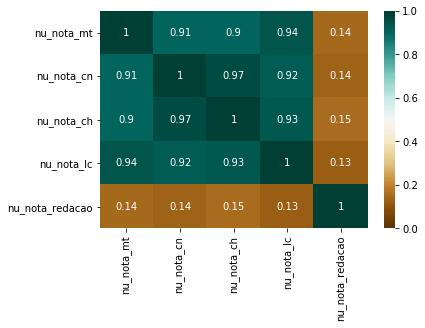

In [16]:
correlations_plot(x_train, vars_notas)

# Análise exploratória

...


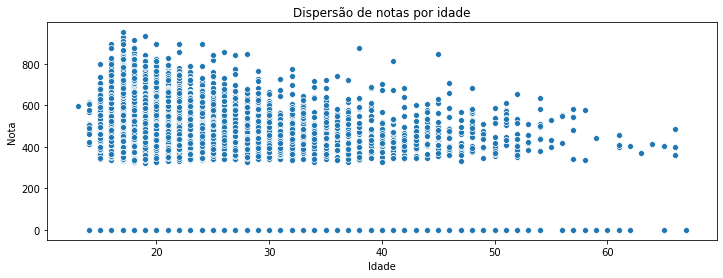

In [17]:
plt.figure(figsize=(12, 4))
ax = sns.scatterplot(x="nu_idade", y="nu_nota_mt", data=x_train)
plt.xlabel('Idade')
plt.ylabel('Nota')
plt.title('Dispersão de notas por idade')
plt.show()

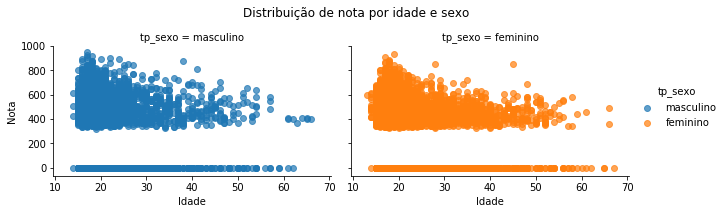

In [18]:
g = sns.FacetGrid(x_train, col="tp_sexo", hue="tp_sexo", aspect=1.5)
g.map(plt.scatter, "nu_idade", "nu_nota_mt", alpha=.7)
g.add_legend()
g.axes[0,0].set_xlabel('Idade')
g.axes[0,1].set_xlabel('Idade')
g.axes[0,0].set_ylabel('Nota')

plt.subplots_adjust(top=0.8)
g.fig.suptitle('Distribuição de nota por idade e sexo');

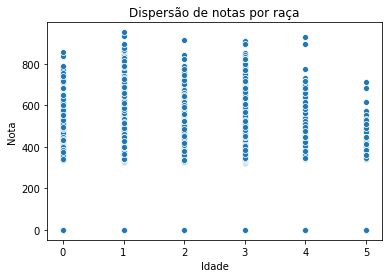

In [19]:
ax = sns.scatterplot(x="tp_cor_raca", y="nu_nota_mt", data=x_train)
plt.xlabel('Idade')
plt.ylabel('Nota')
plt.title('Dispersão de notas por raça')
plt.show()

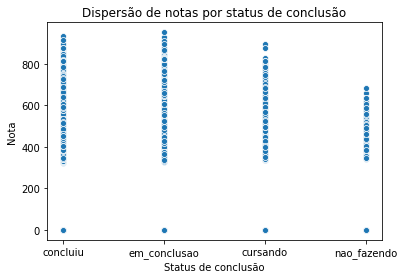

In [20]:
ax = sns.scatterplot(x="tp_st_conclusao_cat", y="nu_nota_mt", data=x_train)
plt.xlabel('Status de conclusão')
plt.ylabel('Nota')
plt.title('Dispersão de notas por status de conclusão')
plt.show()

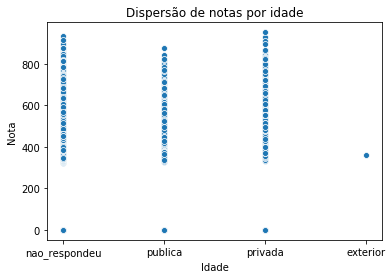

In [21]:
ax = sns.scatterplot(x="tp_escola_cat", y="nu_nota_mt", data=x_train)
plt.xlabel('Idade')
plt.ylabel('Nota')
plt.title('Dispersão de notas por idade')
plt.show()

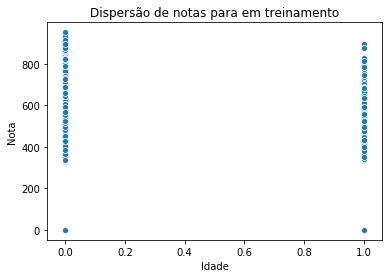

In [22]:
ax = sns.scatterplot(x="in_treineiro", y="nu_nota_mt", data=x_train)
plt.xlabel('Idade')
plt.ylabel('Nota')
plt.title('Dispersão de notas para em treinamento')
plt.show()

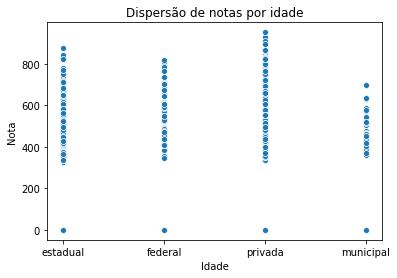

In [23]:
ax = sns.scatterplot(x="tp_dependencia_adm_esc_cat", y="nu_nota_mt", data=x_train)
plt.xlabel('Idade')
plt.ylabel('Nota')
plt.title('Dispersão de notas por idade')
plt.show()

# 3. Análise preditiva
<b>3.1 Descrevendo as métricas</b><br>
<b>3.2 Distribuição dos dados para teste e validação</b><br>
<b>3.3 Busca por melhores parâmetros

In [24]:
x_features = ['nu_nota_cn', 'nu_nota_ch', 'nu_nota_lc', 'nu_nota_redacao',
              'tp_presenca_cn', 'tp_presenca_ch', 'tp_presenca_lc', 'tp_presenca_mt',
             'tp_sexo_feminino','tp_sexo_masculino','nu_idade']
    
X = x_train[x_features]
y = x_train['nu_nota_mt']
train_data, test_data, train_label, test_label = train_test_split(X, y, test_size=0.5, shuffle=False)

# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

model_randf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
scores = cross_val_score(model_randf, train_data, train_label, cv=5)
print('Cross validation score: ', scores.mean())

# GridSearch


from sklearn.model_selection import GridSearchCV

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
max_features = [None, 'auto', 'log2']
max_depth = [None]+[int(x) for x in np.linspace(start = 1, stop = 100, num = 10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_distributions = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
                       
model_randf = RandomForestRegressor(random_state = 42)
clf = GridSearchCV(model_randf, param_grid = param_distributions, cv = 5, verbose=2, n_jobs=-1)
clf.fit(train_data, train_label)

print(clf.best_estimator_)
print('\nbest_params: {}\nbest_score: {}'.format(clf.best_params_, clf.best_score_))

# RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
max_features = [None, 'auto', 'log2']
max_depth = [None]+[int(x) for x in np.linspace(start = 1, stop = 100, num = 10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_distributions = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}


rf = RandomForestRegressor(random_state=42)

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_distributions, n_iter = 33,
                               cv = 5, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(train_data, train_label)


print('best params: {}\nbest score: {}'.format(rf_random.best_params_, rf_random.best_score_))

# Melhor modelo

In [25]:
model_rf = RandomForestRegressor(n_estimators=1000, 
                                 min_samples_split=5,
                                 min_samples_leaf=2,
                                 max_features='log2', 
                                 max_depth=10,
                                 bootstrap=True,
                                 random_state=42)


model_rf.fit(train_data, train_label)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [26]:
pred = model_rf.predict(test_data)
print('mean_squared_error: {}\nr2_score: {}'.format(mean_squared_error(test_label, pred), r2_score(test_label, pred)))

mean_squared_error: 4038.520625953254
r2_score: 0.9233614843717283


In [27]:
def comparar_notas(notas_corretas, notas_preditas, n_notas=10):
    print('nota\tpredição\t\tdiferença')
    for i in range(n_notas):
        print('{}\t{}\t{}'.format(notas_corretas[i], pred[i], notas_corretas[i]-pred[i]))

def analisar_notas(notas_corretas, notas_preditas, max_diferenca=1):
    n_notas = len(notas_corretas)
    print('index\tnota\tpredição\t\tdiferença')
    for i in range(0, n_notas):
        if abs(notas_corretas[i]-pred[i]) > max_diferenca:
            print('{}\t{}\t{}\t{}'.format(i, notas_corretas[i], pred[i], notas_corretas[i]-pred[i]))

#comparar_notas(test_label.tolist(), pred, 10)

#analisar_notas(test_label.tolist(), pred, 200)

# Submissão

In [1]:
x_test = pre_processamento(x_test)
x_test = executar_conclusao(x_test, False)

x_test['tp_presenca_mt'] = x_test['tp_presenca_lc']
X_ = x_test[x_features]

result = model_rf.predict(X_)

answer = pd.DataFrame()
answer['NU_INSCRICAO'] = x_test.nu_inscricao
answer['NU_NOTA_MT'] = result

answer.to_csv('answer.csv', index= False)

NameError: name 'pre_processamento' is not defined

In [29]:
answer

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,422.335292
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,441.648862
2,b38a03232f43b11c9d0788abaf060f7366053b6d,599.117920
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.006804
4,715494628a50142ce8cb17191cfe6d0f3cae0934,544.665953
...,...,...
4571,dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b,444.068615
4572,a75fa8770257e7c9368d059fe53d9ef431f4bdef,489.796782
4573,655fa6306720ff16e825903b5422a46608a77545,690.981182
4574,1f4bc3e3d56212d500625bfe8ac78ccff4362293,467.929875
